In [15]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

INPUT_DIR = "../alignment/alignment_3_agent"
OUTPUT_DIR = "results/3_agent/welfare"  # Output directory for generated images

# Sampling configuration
NUM_SAMPLES_PER_COMBINATION = 20  # Number of times to sample each prompt-bid combination
NUM_PROMPTS = 25
BIDDING_COMBINATIONS_3_AGENT = [ 
    (0.33, 0.33, 0.33),  # All equal
    (0.4, 0.4, 0.2),  # A1 & A2 strong and equal, A3 minor voice
    (0.6, 0.3, 0.1),  # Agent 1 > Agent 2 > Agent 3
    (0.6, 0.2, 0.2),  # Agent 1 > Agent 2 = Agent 3
    (1.0, 0.0, 0.0),  # Agent 1 dominant
]

'''
for k samples for each prompt, generate the following images:
1. heatmap for welfare improvement over the baseline VCG
2. show base_alignment remains high
3. regret from truthful bidding?
'''

'\nfor k samples for each prompt, generate the following images:\n1. heatmap for welfare improvement over the baseline VCG\n2. show base_alignment remains high\n3. regret from truthful bidding?\n'

In [16]:
data = {"prompt": [], "sample": [], "quality_score": [], "bid_1": [], "bid_2": [], "bid_3": [], "base_alignment": [], "agent1_alignment": [], "agent2_alignment": [], "agent3_alignment": []}
for prompt_num in range(NUM_PROMPTS):
    for sample_num in range(NUM_SAMPLES_PER_COMBINATION):
        for bids in BIDDING_COMBINATIONS_3_AGENT:
            filename = f"alignment_p{prompt_num:03}_b{bids[0]:.2f}_{bids[1]:.2f}_{bids[2]:.2f}_s{sample_num:02}.json"
            json_path = os.path.join(INPUT_DIR, filename)
            with open(json_path, 'r') as file:
                sample_data = json.load(file)
                data['prompt'].append(sample_data['metadata']['prompt_index'])
                data['sample'].append(sample_data['metadata']['sample_index'])
                data['quality_score'].append(sample_data['quality_score'])
                data['bid_1'].append(sample_data['metadata']['bids'][0])
                data['bid_2'].append(sample_data['metadata']['bids'][1])
                data['bid_3'].append(sample_data['metadata']['bids'][2])
                data['base_alignment'].append(sample_data['alignment_scores']['base_alignment'])
                data['agent1_alignment'].append(sample_data['alignment_scores']['agent1_alignment'])
                data['agent2_alignment'].append(sample_data['alignment_scores']['agent2_alignment'])
                data['agent3_alignment'].append(sample_data['alignment_scores']['agent3_alignment'])

In [17]:
df = pd.DataFrame.from_dict(data)
df['welfare'] = df['bid_1']*df['agent1_alignment'] + df['bid_2']*df['agent2_alignment'] + df['bid_3']*df['agent3_alignment']
df['best_welfare'] = df.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3'])['welfare'].transform('max')

# Create vcg_baseline: max welfare using alignments from rows where bid_1=1 or bid_2=1, but original bid values
def calculate_vcg_baseline_for_prompt(prompt_df):
    # Get baseline alignment pairs (from rows where bid_1=1 or bid_2=1)
    baseline_rows = prompt_df[(prompt_df['bid_1'] == 1) | (prompt_df['bid_2'] == 1) | (prompt_df['bid_3'] == 1)]
    vcg_baselines = []
    for _, row in prompt_df.iterrows():
        max_welfare = 0
        # Calculate welfare with each baseline alignment pair
        for _, baseline_row in baseline_rows.iterrows():
            welfare = (baseline_row['agent1_alignment'] * row['bid_1'] + 
                      baseline_row['agent2_alignment'] * row['bid_2']+ 
                      baseline_row['agent3_alignment'] * row['bid_3'])
            max_welfare = max(max_welfare, welfare)
        vcg_baselines.append(max_welfare)
    return pd.Series(vcg_baselines, index=prompt_df.index)

df['vcg_baseline'] = df.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)

/tmp/ipykernel_3632721/1413901134.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['vcg_baseline'] = df.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)


In [18]:
welfare_df = df.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3']).first().reset_index()[['prompt', 'bid_1', 'bid_2', 'bid_3', 'best_welfare', 'vcg_baseline']]
welfare_df['diff'] = (welfare_df['best_welfare'] - welfare_df['vcg_baseline']) / welfare_df['vcg_baseline']
welfare_df_cleaned = welfare_df[~welfare_df['prompt'].isin([14, 24, 16, 12, 5])]
welfare_df_cleaned.groupby(['bid_1', 'bid_2', 'bid_3'])['diff'].mean()

bid_1  bid_2  bid_3
0.33   0.33   0.33     0.206906
0.40   0.40   0.20     0.188997
0.60   0.20   0.20     0.080210
       0.30   0.10     0.103025
1.00   0.00   0.00     0.000000
Name: diff, dtype: float64

In [19]:
welfare_df_cleaned.sort_values(by='diff')

,prompt,bid_1,bid_2,bid_3,best_welfare,vcg_baseline,diff
7,1,0.60,0.20,0.20,0.228906,0.237305,-0.035391
57,11,0.60,0.20,0.20,0.224219,0.230664,-0.027942
58,11,0.60,0.30,0.10,0.228418,0.230566,-0.009318
119,23,1.00,0.00,0.00,0.208984,0.208984,0.000000
94,18,1.00,0.00,0.00,0.243164,0.243164,0.000000
...,...,...,...,...,...,...,...
20,4,0.33,0.33,0.33,0.195615,0.144858,0.350389
21,4,0.40,0.40,0.20,0.218066,0.160645,0.357447
15,3,0.33,0.33,0.33,0.235254,0.171768,0.369606
66,13,0.40,0.40,0.20,0.211914,0.152051,0.393706


In [20]:
df_cleaned = df[~df['prompt'].isin([14, 24, 16, 12, 5])]
df_cleaned.to_csv("../results/3_agents/data.csv")

In [24]:
def plot_welfare_over_bids(df, k):
    df = df[df['sample'] < k] # Simulate only k samples
    
    df['welfare'] = df['bid_1']*df['agent1_alignment'] + df['bid_2']*df['agent2_alignment'] + df['bid_3']*df['agent3_alignment']
    df['best_welfare'] = df.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3'])['welfare'].transform('max')
    df['vcg_baseline'] = df.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
    
    welfare_df = df.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3']).first().reset_index()[['prompt', 'bid_1', 'bid_2', 'bid_3', 'best_welfare', 'vcg_baseline']]
    welfare_df['diff'] = (welfare_df['best_welfare'] - welfare_df['vcg_baseline']) / welfare_df['vcg_baseline']

    stats = welfare_df.groupby(['bid_1', 'bid_2', 'bid_3'])['diff'].agg(['mean', 'std', 'count']).reset_index()
    stats['se'] = stats['std'] / np.sqrt(stats['count'])  # Standard error
    error_bars = stats['se']  # Just standard error (smaller)

    stats['bid_combo'] = stats['bid_1'].astype(str) + '/' + stats['bid_2'].astype(str) + '/' + stats['bid_3'].astype(str)
    
    # Create a mapping to ensure proper ordering based on BIDDING_COMBINATIONS_3_AGENT
    combo_order = {}
    for i, (b1, b2, b3) in enumerate(BIDDING_COMBINATIONS_3_AGENT):
        combo_key = f"{b1}/{b2}/{b3}"
        combo_order[combo_key] = i
    
    # Add order column and sort by it
    stats['order'] = stats['bid_combo'].map(combo_order)
    stats = stats.sort_values('order').reset_index(drop=True)
    error_bars = stats['se']  # Update error_bars after sorting
    
    plt.style.use('default')  # White background
    fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
    ax.set_facecolor('white')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    bars = ax.bar(stats['bid_combo'], stats['mean'], 
                yerr=error_bars, 
                capsize=5, 
                alpha=0.8,
                color='steelblue',
                edgecolor='navy',
                linewidth=1.2)
    ax.set_xlabel('Bid Combination (Agent 1 / Agent 2 / Agent 3)', fontsize=15)
    ax.set_ylabel(f'Mean Welfare Improvement ± SE', fontsize=15)
    ax.set_title(f'Welfare Improvement Over VCG Baseline, {k} samples', 
                fontsize=16, pad=20)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='No Improvement')
    for i, (bar, mean_val, err) in enumerate(zip(bars, stats['mean'], error_bars)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + err + 0.001,
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=14)
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=15)
    ax.set_ylim(bottom=-0.005)
    plt.tight_layout()
    return plt

def calculate_vcg_baseline_for_prompt(prompt_df):
    baseline_rows = prompt_df[(prompt_df['bid_1'] == 1) | (prompt_df['bid_2'] == 1) | (prompt_df['bid_3'] == 1)]
    vcg_baselines = []
    for _, row in prompt_df.iterrows():
        max_welfare = 0
        for _, baseline_row in baseline_rows.iterrows():
            welfare = (baseline_row['agent1_alignment'] * row['bid_1'] + 
                      baseline_row['agent2_alignment'] * row['bid_2']+ 
                      baseline_row['agent3_alignment'] * row['bid_3'])
            max_welfare = max(max_welfare, welfare)
        vcg_baselines.append(max_welfare)
    return pd.Series(vcg_baselines, index=prompt_df.index)

In [25]:
def plot_welfare_over_k(df, k_list):
    k_summary = []
    bid_combo_data = {}
    
    for k in k_list:
        df_k = df[df['sample'] < k].copy()
        df_k['welfare'] = df_k['bid_1']*df_k['agent1_alignment'] + df_k['bid_2']*df_k['agent2_alignment'] + df_k['bid_3']*df_k['agent3_alignment']
        df_k['best_welfare'] = df_k.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3'])['welfare'].transform('max')
        df_k['vcg_baseline'] = df_k.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
        
        welfare_df_k = df_k.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3']).first().reset_index()[['prompt', 'bid_1', 'bid_2', 'bid_3', 'best_welfare', 'vcg_baseline']]
        welfare_df_k['diff'] = (welfare_df_k['best_welfare'] - welfare_df_k['vcg_baseline']) / welfare_df_k['vcg_baseline']
        
        # Overall average
        k_summary.append({'k': k, 'mean': welfare_df_k['diff'].mean(), 'se': welfare_df_k['diff'].std()/np.sqrt(len(welfare_df_k))})
        
        # By bid combination - order according to BIDDING_COMBINATIONS_3_AGENT
        bid_stats = welfare_df_k.groupby(['bid_1', 'bid_2', 'bid_3'])['diff'].agg(['mean', 'std', 'count']).reset_index()
        bid_stats['se'] = bid_stats['std'] / np.sqrt(bid_stats['count'])
        bid_stats['bid_combo'] = bid_stats['bid_1'].astype(str) + '/' + bid_stats['bid_2'].astype(str) + '/' + bid_stats['bid_3'].astype(str)
        
        # Create a mapping to ensure proper ordering based on BIDDING_COMBINATIONS_3_AGENT
        combo_order = {}
        for i, (b1, b2, b3) in enumerate(BIDDING_COMBINATIONS_3_AGENT):
            combo_key = f"{b1}/{b2}/{b3}"
            combo_order[combo_key] = i
        
        # Add order column and sort by it
        bid_stats['order'] = bid_stats['bid_combo'].map(combo_order)
        bid_stats = bid_stats.sort_values('order').reset_index(drop=True)
        
        bid_combo_data[k] = bid_stats
    
    k_df = pd.DataFrame(k_summary)
    k_labels = [f'{k}' for k in k_list]  # Categorical labels
    
    plt.style.use('default')  # White background
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='white')
    ax1.set_facecolor('white')
    # ax2.set_facecolor('white')
    
    # Plot 1: Overall average welfare improvement
    bars1 = ax1.bar(k_labels, k_df['mean'], yerr=k_df['se'], capsize=5, alpha=0.8, color='darkgreen', edgecolor='darkblue')
    ax1.tick_params(axis='both', labelsize=14)
    ax1.set_xlabel('Number of Samples (k)', fontsize=15)
    ax1.set_ylabel('Average Welfare Improvement ± SE', fontsize=15)
    ax1.set_title('Average Welfare Improvement vs Sample Size', fontsize=16, pad=20)
    
    for bar, row in zip(bars1, k_df.itertuples()):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + row.se + 0.0003, 
                f'{row.mean:.4f}', ha='center', va='bottom', fontsize=14)
    
    ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Plot 2: By bid combination (now ordered according to BIDDING_COMBINATIONS_3_AGENT)
    bid_combos = bid_combo_data[k_list[0]]['bid_combo'].tolist()
    x_pos = np.arange(len(bid_combos))
    width = 0.2
    
    plt.tight_layout()
    return plt


/tmp/ipykernel_3632721/2989203838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['welfare'] = df['bid_1']*df['agent1_alignment'] + df['bid_2']*df['agent2_alignment'] + df['bid_3']*df['agent3_alignment']
/tmp/ipykernel_3632721/2989203838.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['best_welfare'] = df.groupby(['prompt', 'bid_1', 'bid_2', 'bid_3'])['welfare'].transform('max')
/tmp/ipykernel_3632721/2989203838.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

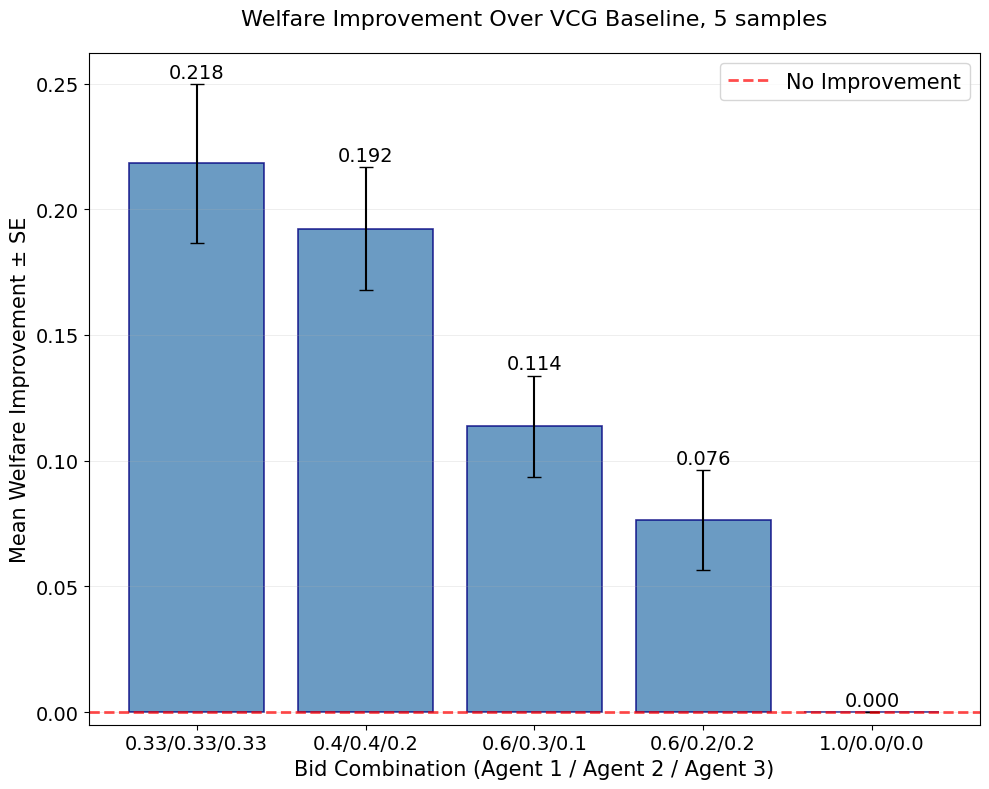

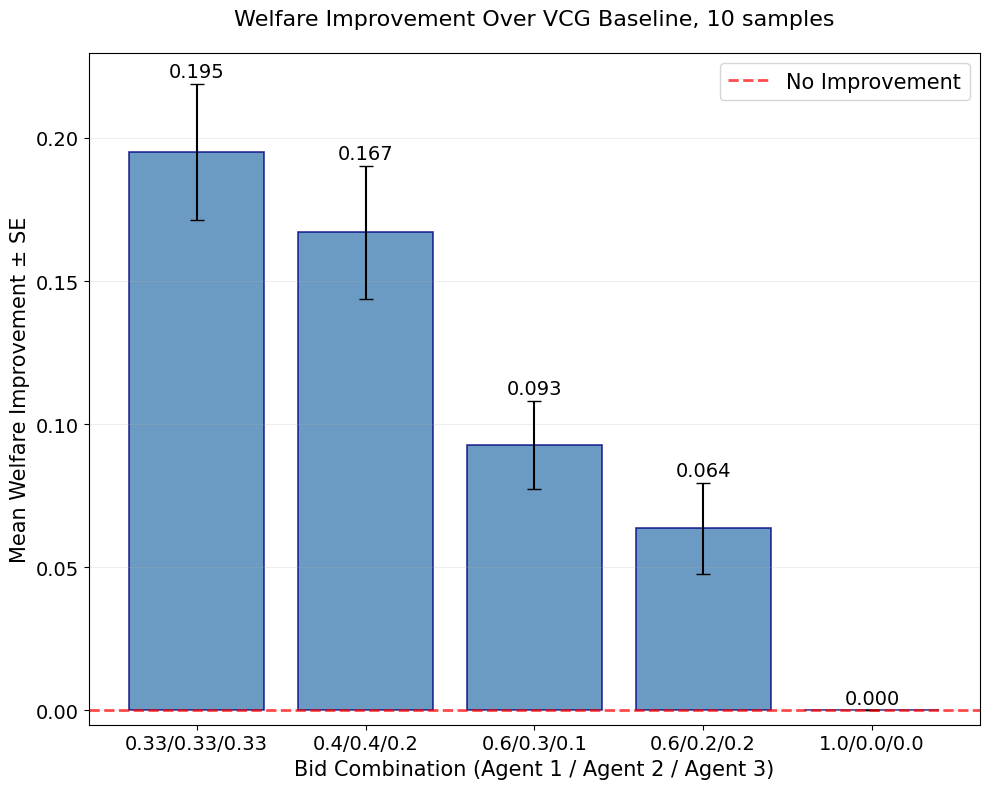

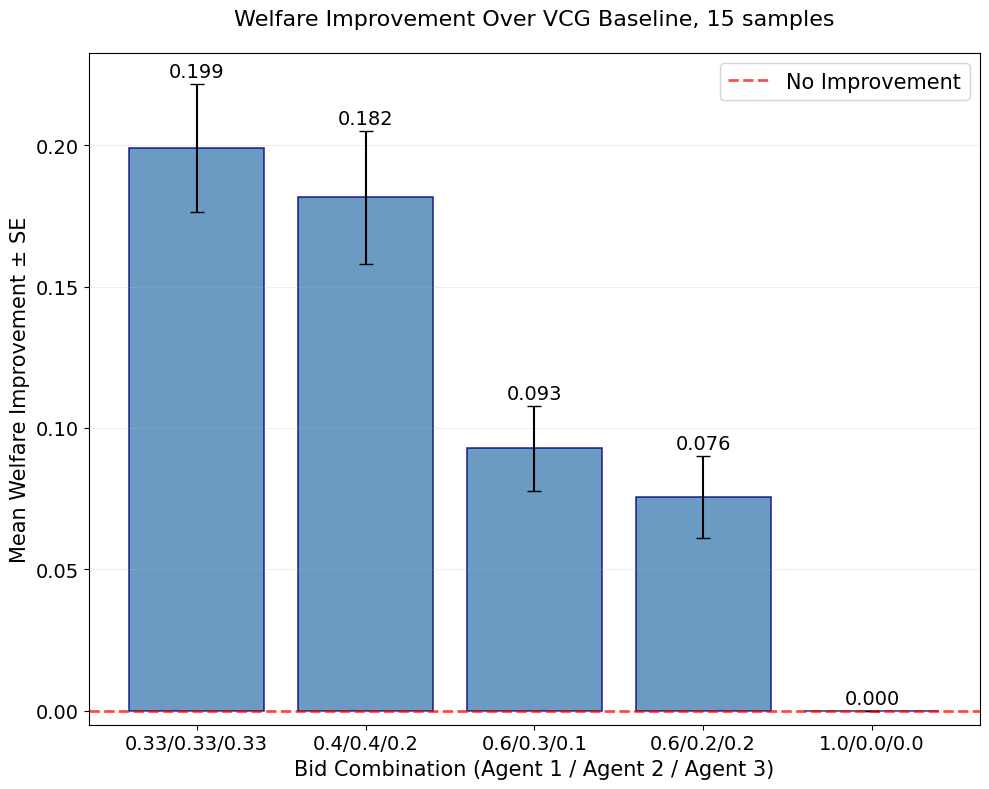

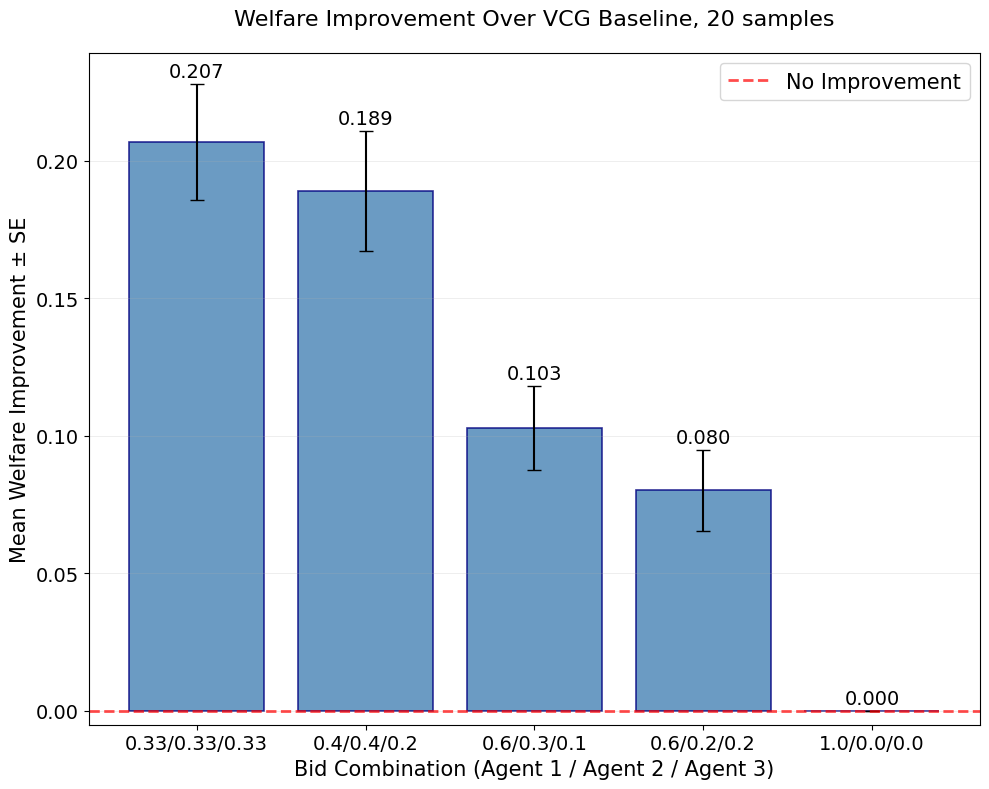

In [26]:
df_cleaned = df[~df['prompt'].isin([14, 24, 16, 12, 5])]
for k in [5, 10, 15, 20]:
    plt = plot_welfare_over_bids(df_cleaned, k)
    plt.savefig(f'../results/3_agents/welfare_{k}.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_3876490/749067869.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_k['vcg_baseline'] = df_k.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
/tmp/ipykernel_3876490/749067869.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_k['vcg_baseline'] = df_k.groupby('prompt').apply(calculate_vcg_baseline_for_prompt).reset_index(level=0, drop=True)
/t

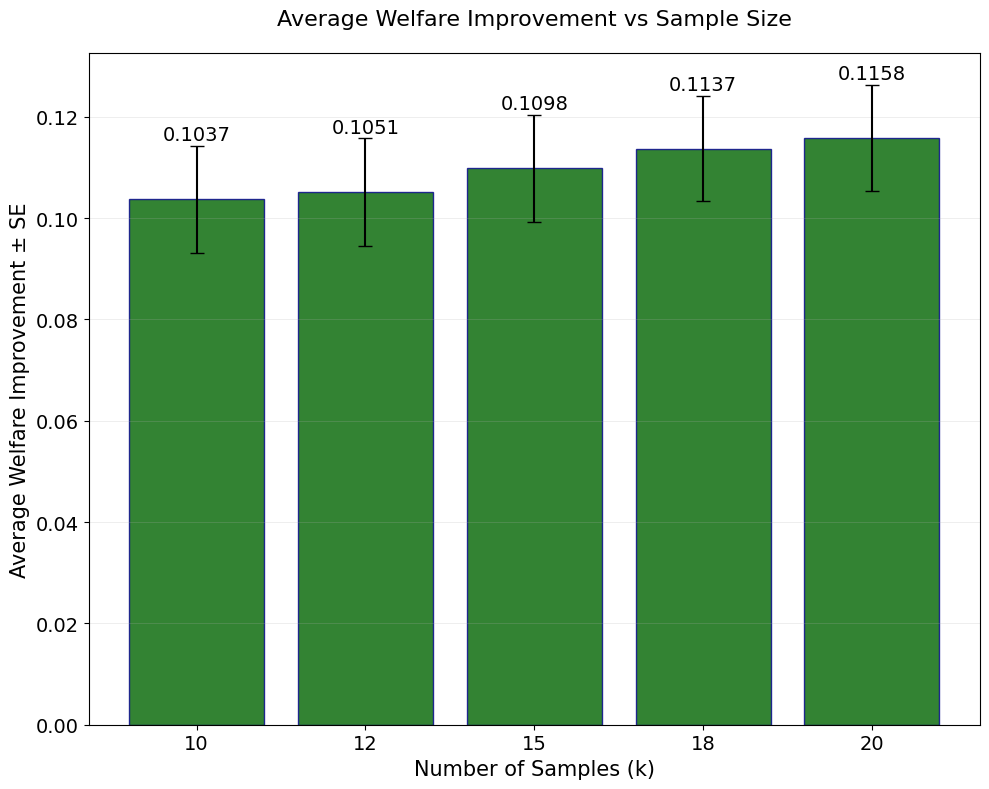

In [31]:
plt = plot_welfare_over_k(df_cleaned, [10, 12, 15, 18, 20])
plt.savefig(f'../results/3_agents/welfare_across_k_3.png', dpi=300, bbox_inches='tight')

In [44]:
df.to_csv("../results/data.csv")